In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Basic Model

In [1]:
import random
from mesa import Model, Agent
from mesa.time import RandomActivation


In [2]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.wealth = 1
    
    def step(self, model):
        if self.wealth == 0:
            return
        other_agent = random.choice(model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
         # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)

    def step(self):
        self.schedule.step()

In [3]:
empty_model = MoneyModel(10)
empty_model.step()

In [7]:
model = MoneyModel(10)
for i in range(10):
    model.step()

(array([ 5.,  0.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 10 Patch objects>)

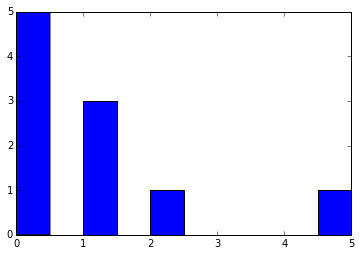

In [8]:
agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

(array([ 440.,  293.,  152.,   74.,   27.,   14.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

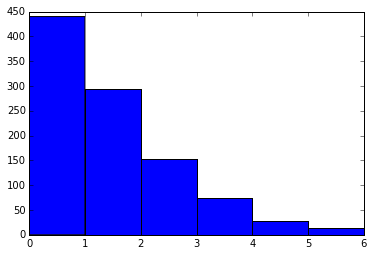

In [37]:
all_wealth = []
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()
    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)
plt.hist(all_wealth, bins=range(max(all_wealth)+1))

# Adding space

In [38]:
from mesa.space import MultiGrid

In [40]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(height, width, True)
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

In [43]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.wealth = 1
    
    def move(self, model):
        possible_steps = model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = random.choice(possible_steps)
        model.grid.move_agent(self, new_position)

    def give_money(self, model):
        cellmates = model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self, model):
        self.move(model)
        if self.wealth > 0:
            self.give_money(model)


In [46]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

In [49]:
import numpy as np

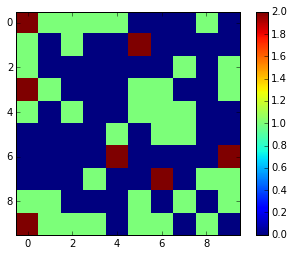

In [54]:
wealth_grid = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    #cell_wealth = sum(a.wealth for a in cell_content) 
    cell_wealth = len(cell_content)
    wealth_grid[y][x] = cell_wealth
plt.imshow(wealth_grid, interpolation='nearest')
plt.colorbar()

# Adding a data collector

In [55]:
from mesa.datacollection import DataCollector

In [56]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

In [97]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.running = True
        self.num_agents = N
        self.grid = MultiGrid(height, width, True)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": lambda a: a.wealth})
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [82]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

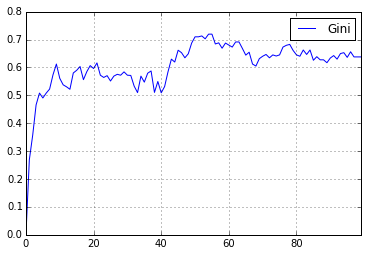

In [83]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [84]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()

In [85]:
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

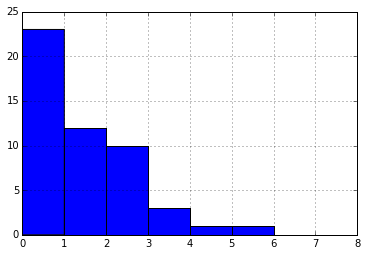

In [86]:
agent_wealth.xs(19, level="Step")["Wealth"].hist(bins=range(agent_wealth.Wealth.max()+1))

In [87]:
one_agent_wealth = agent_wealth.xs(14, level="AgentID")

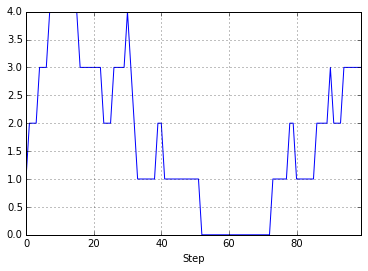

In [88]:
one_agent_wealth.Wealth.plot()

# Batch Run

In [98]:
from mesa.batchrunner import BatchRunner

In [99]:
parameters = {"height": 10, "width": 10, "N": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel, parameters, iterations=5, max_steps=100, 
           model_reporters={"Gini": compute_gini})
batch_run.run_all()

In [102]:
run_data = batch_run.get_model_vars_dataframe()

In [103]:
run_data.head()

,Gini,N,Run,height,width
0,0.653765,360,179,10,10
1,0.621156,150,72,10,10
2,0.651801,190,91,10,10
3,0.650775,230,111,10,10
4,0.689490,140,65,10,10


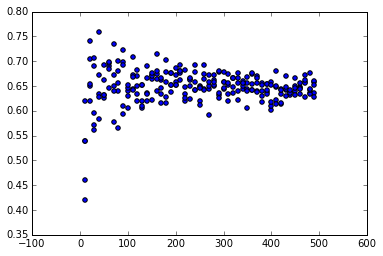

In [104]:
plt.scatter(run_data.N, run_data.Gini)